In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data_path = 'ind1901_2015.csv'
precip_data = pd.read_csv(data_path)

In [3]:
# Prepare data without summing
# Dropping the first column (since it's not numeric data), and handle precipitation values as individual features
precip_data_cleaned = precip_data.drop(columns=['Unnamed: 0']).iloc[2:].reset_index(drop=True)
precip_data_cleaned.index = pd.to_datetime(precip_data.iloc[2:, 0].str[1:], errors='coerce', format='%Y.%m.%d.%H.%M.%S')
precip_data_cleaned = precip_data_cleaned.apply(pd.to_numeric, errors='coerce')  # Ensure all values are numeric


In [4]:
# Scale the data (min-max scaling for all grid points)
scaler = MinMaxScaler(feature_range=(0, 1))
precip_scaled = scaler.fit_transform(precip_data_cleaned)


In [5]:
# Create sequences for LSTM
sequence_length = 30  # Use 30 days to predict the next day
X, y = [], []
for i in range(len(precip_scaled) - sequence_length):
    X.append(precip_scaled[i:i + sequence_length])  # Last 30 days of all grid points
    y.append(precip_scaled[i + sequence_length])    # Next day's values for all grid points
# X: A 3D array of shape (num_samples, sequence_length, num_features)
# y: A 2D array of shape (num_samples, num_features) containing the target values
# and finally converting them to numpy arrays for input to lstm model
X, y = np.array(X), np.array(y)

In [6]:
# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
X.shape

(334, 30, 639)

In [8]:
# Update model for multi-output regression
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(X.shape[2])  # One output for each grid point
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compile and train the model
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics=['accuracy'])
# history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.0000e+00 - loss: 0.0160 - val_accuracy: 0.0185 - val_loss: 0.0190
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0068 - loss: 0.0145 - val_accuracy: 0.0185 - val_loss: 0.0178
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0036 - loss: 0.0128 - val_accuracy: 0.0185 - val_loss: 0.0162
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0036 - loss: 0.0131 - val_accuracy: 0.0185 - val_loss: 0.0155
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0080 - loss: 0.0125 - val_accuracy: 0.0926 - val_loss: 0.0152
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.0370 - loss: 0.0108 - val_accuracy: 0.0926 - val_loss: 0.0149
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0385 - loss: 0.0120 - val_accuracy: 0.0926 - val_loss: 0.0148
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0600 - loss: 0.0121 - val_accuracy: 0.0926 - val_loss: 0.

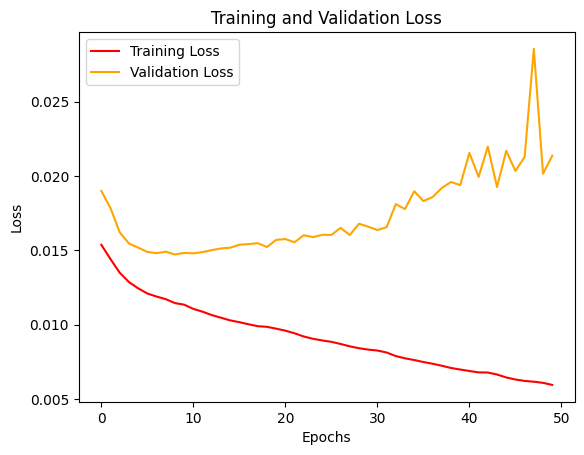

In [10]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss',color='red')
plt.plot(history.history['val_loss'], label='Validation Loss',color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Predict on the last sequence
last_sequence = X[-1].reshape(1, sequence_length, X.shape[2])
predicted_precip = model.predict(last_sequence)
predicted_precip = scaler.inverse_transform(predicted_precip)  # Rescale to original values
print("Predicted precipitation for next day (per grid point):", predicted_precip)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Predicted precipitation for next day (per grid point): [[ 4.40028477e+00  6.51376009e+00  6.70221376e+00  3.60637379e+00
   3.37690663e+00  3.23968267e+00  7.78935528e+00  4.52489853e+00
   3.09446955e+00  3.20273376e+00  3.74273467e+00  2.22016501e+00
   1.44565642e+00  3.02391171e+00  3.70753241e+00  1.88593233e+00
   1.44726980e+00  1.09534156e+00  2.98263144e+00  3.68706155e+00
   4.32752180e+00  2.79196739e+00  1.83717215e+00  3.39083147e+00
   2.44022059e+00  3.44937372e+00  3.15592933e+00  2.58808613e+00
   6.42443323e+00  5.73180485e+00  1.74381185e+00  8.27527165e-01
   1.66612470e+00  1.88376677e+00  1.80815780e+00  1.90799391e+00
   2.87159967e+00  2.05329442e+00  5.40967703e+00  9.20976460e-01
   9.48638618e-01  1.17179656e+00 -3.43165755e-01  6.30470335e-01
   1.66397929e+00  1.93106437e+00  2.83105946e+00  7.78483748e-01
   3.48595715e+00  4.40910482e+00  8.70350063e-01  1.33328223e+00
   1.16065276e+00  1.12795126e+00  7.43345559e-0

In [12]:
predicted_precip.shape

(1, 639)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get predictions on the entire dataset for evaluation
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)  # Rescale to original values
y_true = scaler.inverse_transform(y)  # Original target values

# Replace NaN values with a suitable value (e.g., 0)
# You might need to adjust this based on your data characteristics
predictions = np.nan_to_num(predictions, nan=0.0)
y_true = np.nan_to_num(y_true, nan=0.0)


# Calculate metrics for each grid point individually
mae = mean_absolute_error(y_true, predictions)
rmse = np.sqrt(mean_squared_error(y_true, predictions))


print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Absolute Error (MAE): 3.517025172092089
Root Mean Squared Error (RMSE): 8.860704936600689




---



---



# **THE END OF LSTM**

---



---

